In [1]:
sys.path.append("..")  #
import pandas as pd
from utils.DB import DB
import sys
import matplotlib.pyplot as plt

db = DB()
def get_frame():
    return pd.DataFrame(db.get_entries())


In [10]:
def get_player_win_relation(frame):
    # get the last turn --> won or draw ?
    who_won = pd.DataFrame([turn[-1] for turn in frame.turns])
    # latest_turn == True indicates that the current player won with this move
    player_one_wins = who_won[(who_won.player_id == 0) &
                              (who_won.latest_turn == True)]
    player_two_wins = who_won[(who_won.player_id == 1) &
                              (who_won.latest_turn == True)]
    draws = who_won[who_won.latest_turn == False]
    return {
        'player_one_won': len(player_one_wins),
        'player_two_won': len(player_two_wins),
        'draws': len(draws)
    }

frame = get_frame()
get_player_win_relation(frame)


{'player_one_won': 2, 'player_two_won': 1, 'draws': 0}

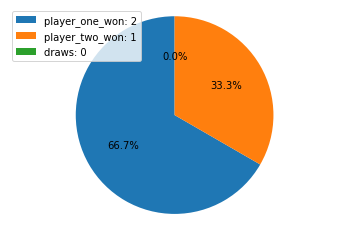

In [12]:
def draw_win_pie(data):
    # https://stackoverflow.com/questions/44076203/getting-percentages-in-legend-from-pie-matplotlib-pie-chart
    plt.pie(data.values(), autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    labels = [f'{key}: {value}' for key, value in data.items()]
    plt.legend(loc = 'best', labels=labels)
    plt.show()


draw_win_pie(get_player_win_relation(frame))


In [13]:
from datetime import datetime
import numpy as np

def avg_game_len(df):
    date_format = "%d.%m.%Y %H:%M:%S"
    date_diff = []
    for index, row in df.iterrows():
        diff = datetime.strptime(row.end_time, date_format) - datetime.strptime(row.start_time, date_format)
        date_diff.append(diff)
    df['game_len'] = date_diff
    game_len_avg = df['game_len'].mean()
    return game_len_avg

def avg_turns(df):
    return np.mean([len(x) for x in df.turns.values]) 


# based on current field, which is the most successful move?
# most succsesful starting move
avg_game_len(frame)
# avg_turns(frame)

Timedelta('0 days 00:00:03')

In [14]:
import copy

def translate_player_symbols(field, symbol_one, symbol_two):
    field = copy.deepcopy(field) 
    for i in range(len(field)):
        for j in range(len(field[0])):
            if field[i][j] == symbol_one:
                field[i][j] = 0 
            elif field[i][j] == symbol_two:
                field[i][j] = 1
    return field 

def transform_turns(df):
    for index, row in df.iterrows():
        symbol_one = row['sign_player1']
        symbol_two = row['sign_player2']

        for i in range(len(row.turns)):
            row.turns[i]['state'] = translate_player_symbols(row.turns[i]['state'], symbol_one, symbol_two)
        df[index] = row
        # print(df[index])
    return df
            
abc = get_frame()
transform_turns(abc).turns[0]
        

[{'player_id': 0,
  'row': 0,
  'column': 0,
  'state': [[0, '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', '']],
  'turn_number': 0,
  'latest_turn': False},
 {'player_id': 1,
  'row': 0,
  'column': 1,
  'state': [[0, 1, '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', '']],
  'turn_number': 1,
  'latest_turn': False},
 {'player_id': 0,
  'row': 1,
  'column': 0,
  'state': [[0, 1, '', '', ''],
   [0, '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', '']],
  'turn_number': 2,
  'latest_turn': False},
 {'player_id': 1,
  'row': 1,
  'column': 1,
  'state': [[0, 1, '', '', ''],
   [0, 1, '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', ''],
   ['', '', '', '', '']],
  'turn_number': 3,
  'latest_turn': False},
 {'player_id': 0,
  'row': 2,
  'column': 0,
  'state': [[0, 1, '', '', ''],
   [0, 1, '', '', ''],
   [0, '',

In [23]:
def stat_move_recommendation(frame, field, player_num, symbol_one, symbol_two):
    moves = []# {'current': [[]], 'next':[[]], 'won': True || False}
    for index, row in frame.iterrows():
        for i in range(len(row.turns)):
            if row.turns[i]['state'] == field:
                i = i+2
                last = row.turns[-1]
                moves.append({'current': field, 'next': row.turns[i]['state'], 'won': last['player_id'] == player_num and last['latest_turn'] == True})
    
    df_recom = pd.DataFrame(moves)
    df_recom['current'] = df_recom['current'].apply(lambda x: '\n'.join([' '.join([str(z) for z in y]) for y in x]))
    df_recom['next'] = df_recom['next'].apply(lambda x:'\n'.join([' '.join([str(z) for z in y]) for y in x]))
    # df_recom = df_recom.explode('current')
    # df_recom = df_recom.explode('next')

    # df_recom['current'] = df_recom['current'].apply(tuple)
    # df_recom['next'] = df_recom['next'].apply(tuple)

    print(df_recom.head())
    # print(df_recom.current[0])
    # print("--------------------------")
    # print(df_recom.next[0])
    groups = df_recom.groupby("next")
    print(groups[groups['won'] == True])


abc = get_frame()
abc = transform_turns(abc)
stat_move_recommendation(abc,abc.turns[0][6]['state'], 0, 'X', 'O')


                               current                                   next  \
0  0 1   \n0 1   \n0 1   \n0    \n      0 1   \n0 1   \n0 1   \n0 1   \n0       
1  0 1   \n0 1   \n0 1   \n0    \n      0 1   \n0 1   \n0 1   \n0 1   \n0       
2  0 1   \n0 1   \n0 1   \n0    \n      0 1   \n0 1   \n0 1   \n0 1 0  \n       

     won  
0   True  
1   True  
2  False  
                               current                                   next  \
0  0 1   \n0 1   \n0 1   \n0    \n      0 1   \n0 1   \n0 1   \n0 1   \n0       
1  0 1   \n0 1   \n0 1   \n0    \n      0 1   \n0 1   \n0 1   \n0 1   \n0       
2  0 1   \n0 1   \n0 1   \n0    \n      0 1   \n0 1   \n0 1   \n0 1 0  \n       

     won  
0   True  
1   True  
2  False  


KeyError: 'Column not found: False'